In [232]:
import sys,os,glob

In [233]:
sys.path.append('/home/simon/git/pymzm')
sys.path.append('/home/simon/git/mass-spec-utils')

In [234]:
condition = 1
ion_mode = 'Pos'

In [235]:
mzml_folder = '/home/simon/data/lipid_files/lipid_files/Condition_{}/{}/'.format(condition,ion_mode)
pp_folder = os.path.join(mzml_folder,'picked_peaks_relaxed')

In [236]:
mzml_file_list = glob.glob(os.path.join(mzml_folder,'*.mzML'))

pos = mzml_file_list.index('/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/24_pp_s3_pos_1.mzML')
del mzml_file_list[pos]
mzml_pp = []
for m in mzml_file_list:
    final_part = m.split(os.sep)[-1]
    pp_name = final_part.split('.')[0] + '_box.csv'
    mzml_pp.append((m,os.path.join(pp_folder,pp_name)))
    
for m,p in mzml_pp:
    print(m,p)

/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/0_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/0_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/48_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/48_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/96_pp_d20_.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/96_pp_d20__box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/72_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/72_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/8_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/8_pp_d20_pos_1_box.csv


In [237]:
from ms2_matching import load_picked_boxes,MZMLFile

In [238]:
all_boxes = {}
for m,p in mzml_pp:
    all_boxes[p] = load_picked_boxes(p)

In [239]:
all_mzml_file_obj = {}
for m,p in mzml_pp:
    all_mzml_file_obj[p] = MZMLFile(m)

Loaded 1968 scans
Loaded 1968 scans
Loaded 1967 scans
Loaded 1968 scans
Loaded 1968 scans


In [240]:
from chromatograms import add_chromatograms_to_boxes
for p in all_boxes:
    add_chromatograms_to_boxes(all_boxes[p],all_mzml_file_obj[p])
    

In [241]:
def find_boxes(boxes,mz,rt_in_seconds,mz_tol = 0.1,rt_tol = 10):
    sub_boxes = list(filter(lambda x: abs(x.mz - mz) <= mz_tol and 
                            abs(x.rt_in_seconds - rt_in_seconds) <= rt_tol,boxes))
    return sub_boxes

In [242]:
# order files by time
ordered_files = list(all_boxes.keys())
ordered_files.sort(key = lambda x: int(x.split(os.sep)[-1].split('_')[0]))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PC 34:1 ('C42H82NO8P', 'C42H81DNO8P', 760.5836, 628.2, '[M+H]+')
PC 34:2 ('C42H80NO8P', 'C42H79DNO8P', 758.5677, 586.8, '[M+H]+')
PC 34:0 ('C42H84NO8P', 'C42H83DNO8P', 762.5997, 672.0, '[M+H]+')
PC 34:0p ('C42H84NO7P', 'C42H83DNO7P', 746.8044, 661.8, '[M+H]+')
PC 38:5p ('C43H76NO7P', 'C43H75DNO7P', 750.5421, 637.8000000000001, '[M+H]+')
PC 38:4p ('C43H78NO7P', 'C43H77DNO7P', 752.5577, 678.0, '[M+H]+')


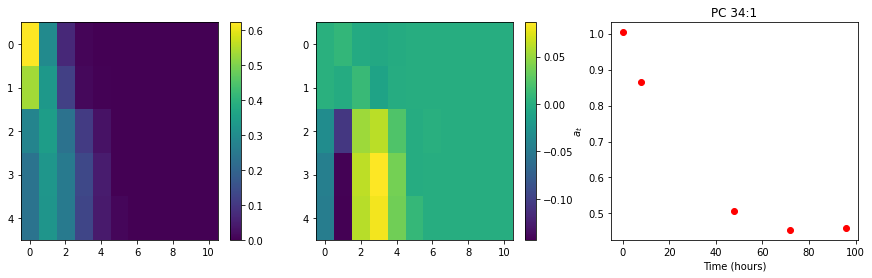

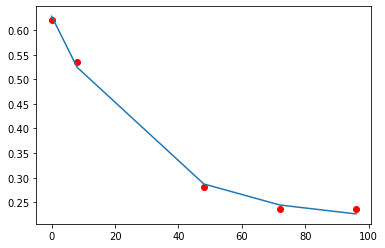

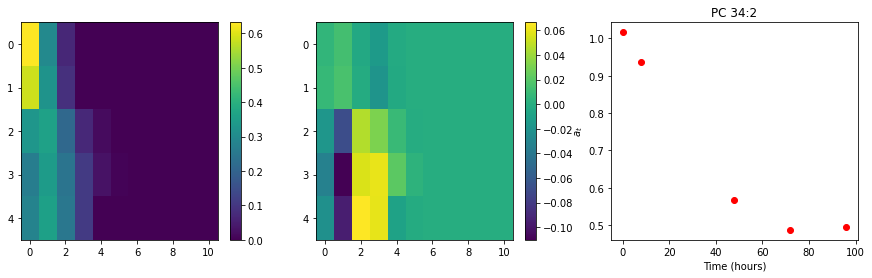

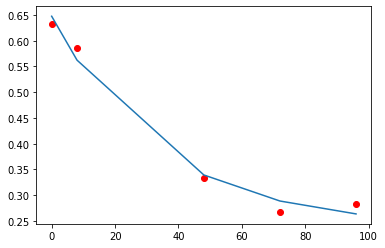

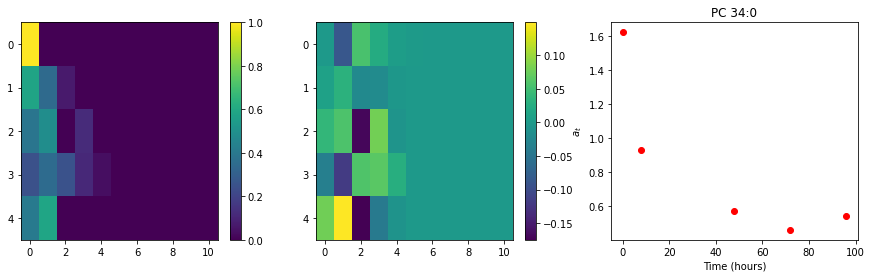

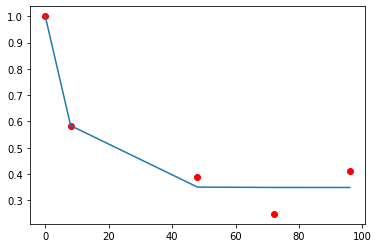

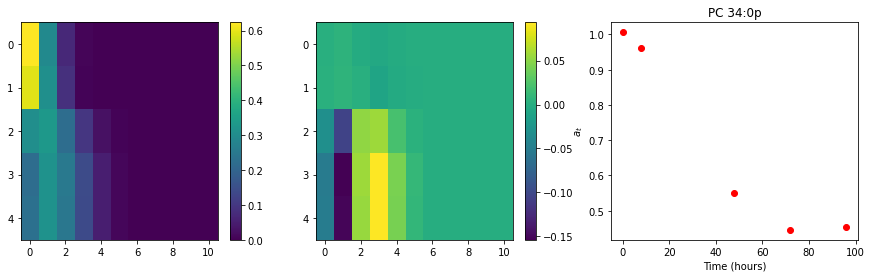

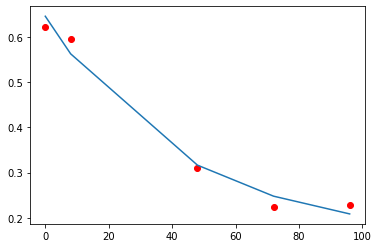

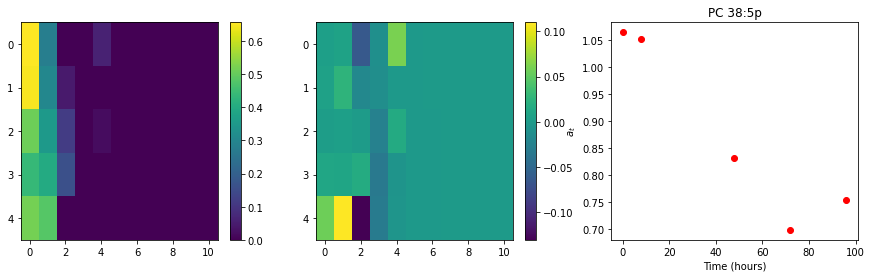

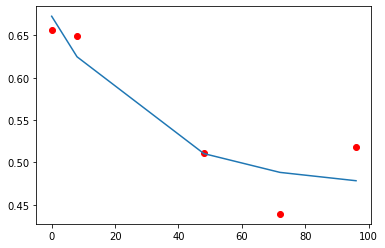

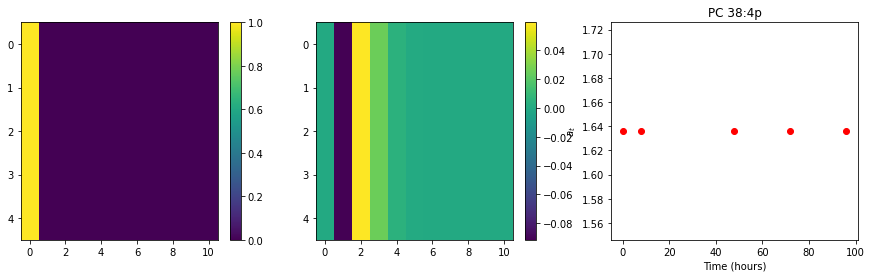

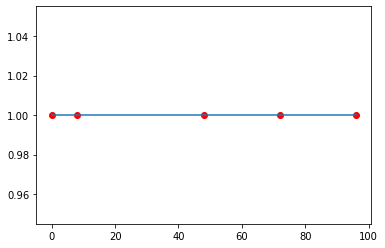

In [246]:
%load_ext autoreload
%autoreload 2
from molmass import Formula
from adduct_rules import AdductTransformer
import numpy as np
import pylab as plt
%matplotlib inline
at = AdductTransformer()
all_data = {}
rates = {}
from chromatograms import peak_group
lipids = {'PC 34:1':('C42H82NO8P','C42H81DNO8P',760.5836,10.47*60,'[M+H]+'),
          'PC 34:2':('C42H80NO8P','C42H79DNO8P',758.5677,9.78*60.0,'[M+H]+'),
          'PC 34:0':('C42H84NO8P','C42H83DNO8P',762.5997,11.2*60.0,'[M+H]+'),
          'PC 34:0p':('C42H84NO7P','C42H83DNO7P',746.8044,11.03*60.0,'[M+H]+'),
          'PC 38:5p':('C43H76NO7P','C43H75DNO7P',750.5421,10.63*60.0,'[M+H]+'),
          'PC 38:4p':('C43H78NO7P','C43H77DNO7P',752.5577,11.3*60.0,'[M+H]+'),
         }
for lipid,dets in lipids.items():
    print(lipid,dets)
    f = Formula(dets[0])
#     print("Mono: ",f.isotope.mass)
    if ion_mode == 'Pos':
        mz = at.mass2ion(f.isotope.mass,dets[4])
    rt = dets[3]
#     print(mz,rt)
    
    
    normal_spec = f.spectrum()
    heavy_spec = Formula(dets[1]).spectrum()

    mz_vals = []
    x = []
    y = []
    for key,(m,i) in normal_spec.items():
        temp_mz = at.mass2ion(m,dets[4])
        mz_vals.append(int(temp_mz))
        x.append(i)
        y.append(heavy_spec.get(key,(0,0))[1])

    n_rows = len(ordered_files)
    n_cols = len(x)

    data_mat = np.zeros((n_rows,n_cols),np.double)

    for i,o in enumerate(ordered_files):
        l = find_boxes(all_boxes[o],mz,rt,rt_tol = 10)
        if len(l) == 0:
            print("YUK")
            print("Failed with ({},{}) in {}".format(mz,rt,o))
        elif len(l) > 1:
            # take the most intenste
#             l.sort(key = lambda x: x.height,reverse = True)
            # take the closest in mz
            l.sort(key = lambda x: abs(x.mz - mz))
            l = l[0]
        else:
            l = l[0]
#         assert len(l) == 1,print([(mz,b.mz,b.rt_in_seconds,b.height) for b in l])
        g = peak_group(all_boxes[o],l,threshold = 0.75,max_mz_diff = 10)
#         print(len(g))
        
        
        for box in g:
            for j,m in enumerate(mz_vals):
                if int(box.mz) == m:
                    data_mat[i,j] = box.area
    data_mat /= data_mat.sum(axis=1)[:,None]
#     plt.imshow(data_mat,aspect='auto')
#     plt.colorbar()
    
    x = np.array(x)
    y = np.array(y)

    recon = []

    all_a = []
    for row in data_mat:
        mask = (row > 0) # check this...need to be confident that the same peaks are picked in each file...
        f = row - y
        m = x-y
        a = ((f[mask]*m[mask]).sum())/((m[mask]*m[mask]).sum())
        all_a.append(a)
        recon.append(a*x + (1-a)*y)

    recon = np.array(recon)
    times = [int(x.split(os.sep)[-1].split('_')[0]) for x in ordered_files]

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.imshow(data_mat,aspect='auto')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(data_mat - recon,aspect='auto')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(times,all_a,'ro')
    plt.xlabel('Time (hours)')
    plt.ylabel('$a_t$')
    plt.title(lipid)
    
    p = fit(times,data_mat,fix_ends = False)

    rates[lipid] = p
    
    all_data[lipid] = np.copy(data_mat)


    

In [244]:
for lipid in rates:
    print(lipid,"k = {:.3f}, a_0 = {:.3f}, a_i = {:.3f}".format(rates[lipid][0],rates[lipid][1],rates[lipid][2]))

PC 34:1 k = 0.036, a_0 = 0.628, a_i = 0.213
PC 34:2 k = 0.029, a_0 = 0.648, a_i = 0.239
PC 34:0 k = 0.127, a_0 = 1.000, a_i = 0.349
PC 34:0p k = 0.023, a_0 = 0.647, a_i = 0.156
PC 38:5p k = 0.034, a_0 = 0.673, a_i = 0.471
PC 38:4p k = 0.050, a_0 = 1.000, a_i = 1.000


# Curve fitting

- Fitting the curve $y = a_0 + (a_\infty - a_0)(1-\exp(-kt))$ to the monoisotopic data for each lipid

In [230]:
def min_func(x,*args):
    # x = k: the rate constant
    # *args
    p = args
    if p[0] == True:
        # fix ends is true - fix the end points from the data - not recommended
        t = p[1]
        data = p[2]
        a0 = p[3]
        ai = p[4]
        
        k = x[0]
    else:
        t = p[1]
        data = p[2]
        
        k = x[0]
        a0 = x[1]
        ai = x[2]

    preds = a0 + (ai-a0)*(1-np.exp(-k*t))
    return ((preds-data)**2).sum()


def fit(times,data_mat,fix_ends = True,make_plot = True,options = {},method = 'L-BFGS-B'):

    t = np.array(times)
    
    a0 = data_mat[0,0]
    ai = data_mat[-1,0]
        
    k = 0.05
    
    if fix_ends:
        args = (fix_ends,t,data_mat[:,0],a0,ai)
        zinit = [k]
    else:
        args = (fix_ends,t,data_mat[:,0])
        zinit = [k,a0,ai]
    
    end = minimize(min_func,zinit,args = args,method = method)
    
    if fix_ends:
        k = end['x'][0]
    else:
        k = end['x'][0]
        a0 = end['x'][1]
        ai = end['x'][2]
    
    if make_plot:
        plt.figure()
        plt.plot(t,data_mat[:,0],'ro')
        plt.plot(t,a0 + (ai-a0)*(1-np.exp(-k*t)))
    
    return (k,a0,ai)

(0.05, 1.0, 1.0)


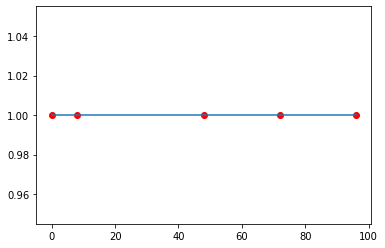

In [229]:
p = fit(times,data_mat,fix_ends = False)
print(p)

In [318]:
from molmass import Formula
ion_mode = 'Pos'
sys.path.append('/Users/simon/git/mass-spec-utils')
from adduct_rules import AdductTransformer
from chromatograms import isotope_group
at = AdductTransformer()
isotopes = {l:{} for l in lipids}
for lipid,dets in lipids.items():
    print(lipid,dets)
    f = Formula(dets[0])
    if ion_mode == 'Pos':
        mz = at.mass2ion(f.isotope.mass,dets[4])
    rt = dets[3]
    print('\t',mz,rt)
    for o in all_mzml_file_obj:
        l = find_boxes(all_boxes[o],mz,rt,mz_tol = 0.01,rt_tol = 10)
        print('\tFound {} boxes'.format(len(l)))
        isos = {}
        for box in l:
            isos[box] = isotope_group(all_boxes[o],box,iso_mz_tol=0.1)
        ib = [(box,len(isos[box]),box.height) for box in isos]
        ib.sort(key = lambda x: x[1],reverse = True)
        print(ib)
        choice = ib[0][0] # chosen A0 peak
        isotopes[lipid][o] = isos[choice]

PC 34:1 ('C42H82NO8P', 'C42H81DNO8P', 760.5836, 628.2, '[M+H]+')
	 760.5850820543608 628.2
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26e4feeef0>, 4, 69338856.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26da266a58>, 7, 29429962.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f270b57c470>, 7, 21282368.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26eb5fd208>, 6, 24771870.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26f5008ac8>, 5, 56244772.0)]
PC 34:2 ('C42H80NO8P', 'C42H79DNO8P', 758.5677, 586.8, '[M+H]+')
	 758.5694319899007 586.8
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26e5ee4da0>, 3, 25631106.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26d72ac7b8>, 5, 11565212.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f270b57c3c8>, 4, 7773879.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26eb5fd780>, 6, 8202413.0)]
	Found 1 boxes
[(<ms2_matching.PickedBox object at 0x7f26f4fd151

In [316]:
for lipid in lipids:
    print(lipid)
    for filename in ordered_files:
        isos = isotopes[lipid][filename]
        print(filename,len(isos))

PC 34:1
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/0_pp_d20_pos_1_box.csv 4
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/8_pp_d20_pos_1_box.csv 5
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/48_pp_d20_pos_1_box.csv 7
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/72_pp_d20_pos_1_box.csv 6
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/96_pp_d20__box.csv 7
PC 34:2
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/0_pp_d20_pos_1_box.csv 3
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/8_pp_d20_pos_1_box.csv 3
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/48_pp_d20_pos_1_box.csv 5
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/72_pp_d20_pos_1_box.csv 6
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/

/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/0_pp_d20_pos_1_box.csv 4
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/8_pp_d20_pos_1_box.csv 5
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/48_pp_d20_pos_1_box.csv 7
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/72_pp_d20_pos_1_box.csv 7
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/96_pp_d20__box.csv 7
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/0_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/8_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/48_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/72_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks_relaxed/96_

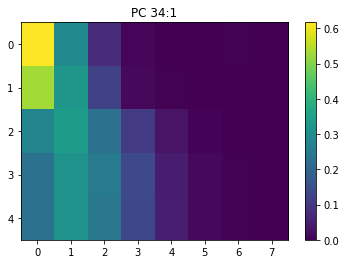

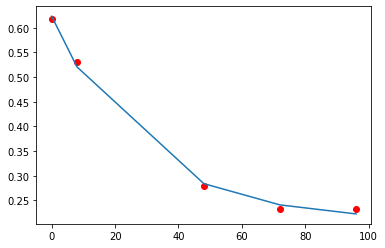

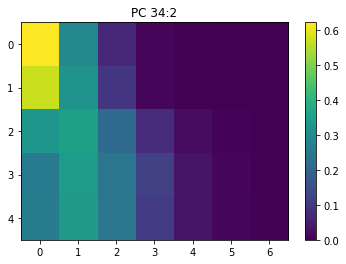

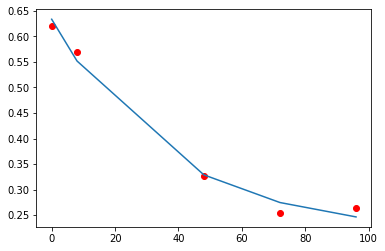

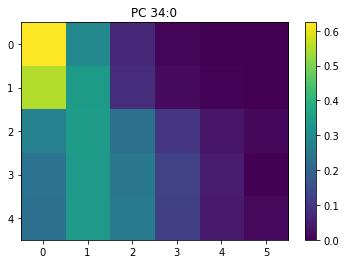

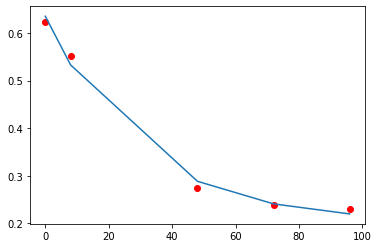

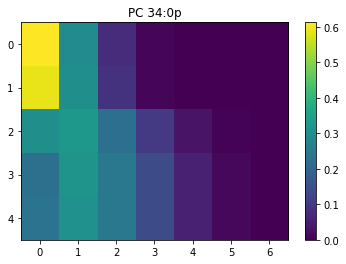

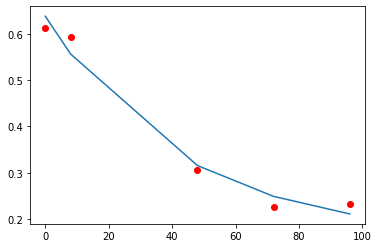

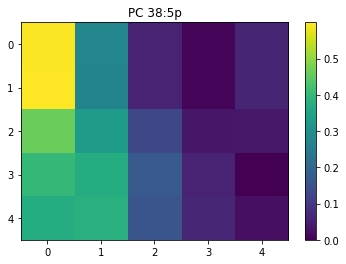

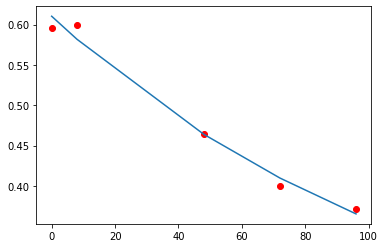

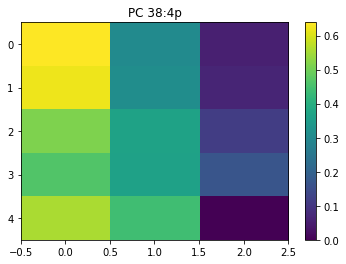

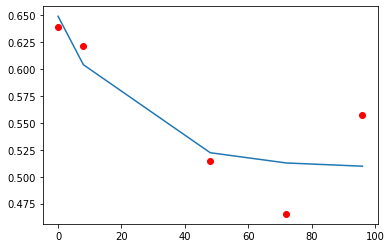

In [319]:
lipid = 'PC 34:1'
for lipid in lipids:
    max_iso = 0
    PROTON_MASS = 1.00727645199076

    for filename in ordered_files:
        max_iso = max(max_iso,len(isotopes[lipid][filename]))
        print(filename,max_iso)


    scan_delta = 2 # plus and minus two oscans
    mz_tol = 0.1

    data_mat = np.zeros((len(ordered_files),max_iso+1))
    for j,filename in enumerate(ordered_files):
        print(filename)
        for i,box in enumerate(isotopes[lipid][filename]):
            data_mat[j,i] = box.height
    for j,filename in enumerate(ordered_files):
        if len(isotopes[lipid][filename]) < max_iso:
            # attempt to fill in
            for i in range(len(isotopes[lipid][filename]),max_iso+1):
                target_mz = isotopes[lipid][filename][0].mz + i*PROTON_MASS
                apex_scan = get_scan_max_intensity(isotopes[lipid][filename][0].peak_chromatogram)
                scans = np.arange(apex_scan - scan_delta,apex_scan + scan_delta + 1)
                min_mz = target_mz - mz_tol
                max_mz = target_mz + mz_tol
                intensity = get_max_intensity(all_mzml_file_obj[filename],scans,min_mz,max_mz)
                data_mat[j,i] = intensity


    data_mat /= data_mat.sum(axis=1)[:,None]
    plt.figure()
    plt.imshow(data_mat,aspect='auto')
    plt.title(lipid)
    plt.colorbar()

    p = fit(times,data_mat,fix_ends = False)

In [291]:
def get_scan_max_intensity(chromatogram):
    i = np.argmax(chromatogram.intensity_list)
    return chromatogram.scan_n_list[i]
def get_max_intensity(mzml_file_obj,scans,min_mz,max_mz):
    max_i = 0.0
    for scan_no in scans:
        max_i = max(max_i,get_max_scan_intensity(mzml_file_obj.scans[scan_no],min_mz,max_mz))
    return max_i
    

In [287]:
def get_max_scan_intensity(scan,min_mz,max_mz):
    mz_vals,intensity_vals = zip(*scan.peaks)
    mz_vals = np.array(mz_vals)
    intensity_vals = np.array(intensity_vals)
    pos = np.where((mz_vals >= min_mz) * (mz_vals <= max_mz))[0]
    if len(pos) > 0:
        return max(intensity_vals[pos])
    else:
        return 0.0